In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Q3 API
from layers import dense 

In [4]:
epochs = 20
batch_size = 500
learning_rate = 0.01

In [5]:
mnist = np.load('mnist.npz')

In [6]:
# split training data (60,000) into 55,000 for train and 5,000 for validate images
train, x_test = mnist['x_train'], mnist['x_test']
train = train.reshape((60000, 784))/255
x_train = train[:55000].copy()
x_val = train[55000:].copy()
x_test = x_test.reshape((10000, 784))/255
# labels
train_labels = mnist['y_train']
y_train = np.eye(10)[train_labels[:55000]]
y_val = np.eye(10)[train_labels[55000:]]
y_test = np.eye(10)[mnist['y_test']]

In [7]:
# input
x_p = tf.placeholder(tf.float32, [None, 784])
# output
y_p = tf.placeholder(tf.float32, [None, 10])

In [8]:
hidden1 = dense(x=x_p, in_length=784, neurons=300, activation=tf.nn.relu, layer_name='Layer_1', dev=0.08)
hidden2 = dense(x=hidden1, in_length=300, neurons=100, activation=tf.nn.relu, layer_name='Layer_2', dev=0.08)
output = dense(x=hidden2, in_length=100, neurons=10, activation=tf.nn.softmax, layer_name='Layer_Output')
y_clipped = tf.clip_by_value(output, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y_p * tf.log(y_clipped)+ (1 - y_p) * tf.log(1 - y_clipped), axis=1))
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [9]:
labels = tf.argmax(y_p, 1)
predictions = tf.argmax(output, 1)

In [10]:
acc, acc_op = tf.metrics.accuracy(labels, predictions)

In [11]:
conmat = tf.confusion_matrix(labels, predictions)

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    avg_loss = []
    validate_accuracy = []
    total_batches = x_train.shape[0] // batch_size
    
    # Training
    for e in range(epochs):
        avg_loss.append(0.0)
        for b in range(total_batches):
            start = b*batch_size
            end = (b+1)*batch_size
            batch = sess.run([optimiser, cross_entropy], 
                     feed_dict={x_p: x_train[start:end], y_p: y_train[start:end]})
            avg_loss[e] += batch[1] / total_batches
        
        # Validation
        accuracy = sess.run(acc_op,
                 feed_dict={x_p: x_val, y_p: y_val})
        validate_accuracy.append(accuracy)
        print("Epoch: {:2d}".format(e + 1), "train_loss =", "{:.4f}".format(avg_loss[e]), "validate_accuracy =", "{:.4f}".format(validate_accuracy[e]))
        
    # Testing
    test_accuracy, confusion_mat = sess.run([acc_op, conmat],
                    feed_dict={x_p:x_test, y_p:y_test})
    
    print('Testing Accuracy:', test_accuracy)
    print('Confusion Matrix:', confusion_mat)
    
    tf.io.write_graph(sess.graph_def, 'graphs/', 'mnist-v2.pbtxt')    

Epoch:  1 train_loss = 1.4346 validate_accuracy = 0.8896
Epoch:  2 train_loss = 0.6363 validate_accuracy = 0.9033
Epoch:  3 train_loss = 0.5131 validate_accuracy = 0.9119
Epoch:  4 train_loss = 0.4452 validate_accuracy = 0.9179
Epoch:  5 train_loss = 0.3996 validate_accuracy = 0.9222
Epoch:  6 train_loss = 0.3655 validate_accuracy = 0.9257
Epoch:  7 train_loss = 0.3386 validate_accuracy = 0.9287
Epoch:  8 train_loss = 0.3169 validate_accuracy = 0.9314
Epoch:  9 train_loss = 0.2986 validate_accuracy = 0.9336
Epoch: 10 train_loss = 0.2830 validate_accuracy = 0.9356
Epoch: 11 train_loss = 0.2694 validate_accuracy = 0.9373
Epoch: 12 train_loss = 0.2572 validate_accuracy = 0.9390
Epoch: 13 train_loss = 0.2463 validate_accuracy = 0.9405
Epoch: 14 train_loss = 0.2365 validate_accuracy = 0.9419
Epoch: 15 train_loss = 0.2275 validate_accuracy = 0.9431
Epoch: 16 train_loss = 0.2192 validate_accuracy = 0.9443
Epoch: 17 train_loss = 0.2115 validate_accuracy = 0.9454
Epoch: 18 train_loss = 0.2044 v

In [14]:
np.savetxt('mnistv2-conmat.txt', confusion_mat, fmt='%4d', delimiter=' & ', newline='\\\\\ \hline\n')

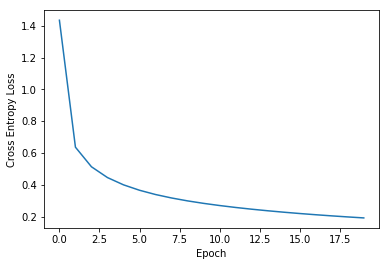

In [15]:
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.plot(avg_loss[None:])
plt.show()

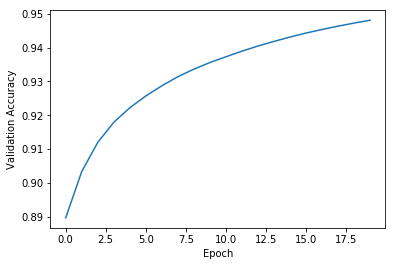

In [16]:
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.plot(validate_accuracy)
plt.show()

In [17]:
True_positives = np.diag(confusion_mat)
False_positives = np.sum(confusion_mat, axis=1) - True_positives
False_negatives = np.sum(confusion_mat, axis=0) - True_positives
Precision = True_positives / (True_positives + False_positives)
print("Precision:", Precision)
Recall = True_positives / (True_positives + False_negatives)
print("\nRecall:", Recall)
F_scores = (2*Precision*Recall) / (Recall+Precision)
print("\nF_scores:", F_scores)

Precision: [0.98163265 0.97797357 0.95348837 0.95247525 0.96639511 0.94282511
 0.95511482 0.94844358 0.95174538 0.91873142]

Recall: [0.97863683 0.98143236 0.95256534 0.94406281 0.94333996 0.94600675
 0.96723044 0.95494613 0.92238806 0.95863495]

F_scores: [0.98013245 0.97969991 0.95302663 0.94825037 0.95472837 0.94441325
 0.96113445 0.95168375 0.93683679 0.93825911]


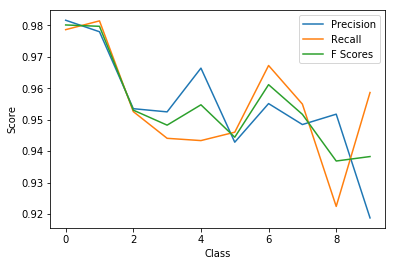

In [18]:
plt.plot(Precision, label='Precision')
plt.plot(Recall, label='Recall')
plt.plot(F_scores, label='F Scores')
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend()
plt.show()